In [1]:
%matplotlib inline

In [2]:
import numpy as np
from io import StringIO
from astropy.constants import c
import matplotlib.pyplot as plt
import itertools
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation
from io import BytesIO
import base64
from astropy.io import fits
import cmcrameri.cm as cmc

In [36]:
c_const = c.value
frequency  = 93.7*1e9
wavelength = c_const/frequency

In [4]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": "pdflatex",  # default is xetex
    }
)

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize

In [5]:
def weighting_scheme(weights, uv_pix_1d, N, scheme="natural", robust_param=2.):
    weights_bincount = np.bincount(uv_pix_1d, weights, minlength=N*N)
    weights_w_1d = weights_bincount[uv_pix_1d]
    
    if scheme.lower() == "natural":
        return weights
    elif scheme.lower() == "uniform":
        return weights/weights_w_1d
    elif scheme.lower() == "robust":
        f_squared_num = (5.* np.power(10, -robust_param))**2
        f_squared_den = np.sum(weights_w_1d**2)/np.sum(weights)
        f_squared = f_squared_num/f_squared_den
        return weights/(1.+(weights_w_1d*f_squared))
    else:
        raise ValueError("Not known scheme")

In [6]:
def calc_R(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [7]:
def _altaz_to_earthlocation(altaz):
    local_itrs = altaz.transform_to(ITRS(location=altaz.location))
    itrs = ITRS(local_itrs.cartesian + altaz.location.get_itrs().cartesian)
    return itrs.earth_location

In [8]:
def _earthlocation_to_altaz(location, reference_location):
    # See
    # https://docs.astropy.org/en/stable/coordinates/common_errors.html#altaz-calculations-for-earth-based-objects
    # for why this is necessary and we cannot just do
    # `get_itrs().transform_to(AltAz())`
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [9]:
def local_to_earth_location(x, y, z, reference_location):
    cart = CartesianRepresentation(x, y, z)
    altaz = AltAz(cart, location=reference_location)
    return _altaz_to_earthlocation(altaz)

In [10]:
def earth_location_to_local_enu(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    ned_coords =  altaz.cartesian.xyz
    enu_coords = ned_coords[1], ned_coords[0], -ned_coords[2]
    return np.array(enu_coords)

In [11]:
def enu_to_local_altaz(enu_baselines, distance):
    elevation = np.arctan2(enu_baselines[0], enu_baselines[1])
    azimuth = np.arcsin(enu_baselines[2]/distance)
    return elevation, azimuth

In [12]:
def b_enu_to_b_equatorial(b_enu, lat_obs):
    """
    b_enu: coordenadas de los baselines en el sistema de referencia plano tangente local (ENU)
    lat_obs: latitud del centro del observatorio, expresado en radianes
    """
    abs_b = np.sqrt(np.sum(b_enu**2, axis=0))
    
    azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

    x_equatorial = np.cos(lat_obs) * np.sin(elevation) - np.sin(lat_obs) * np.cos(elevation) * np.cos(azimuth)
    y_equatorial = np.cos(elevation) * np.sin(azimuth)
    z_equatorial = np.sin(lat_obs) * np.sin(elevation) + np.cos(lat_obs) * np.cos(elevation) * np.cos(azimuth)
    baseline_equatorial = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])
    return baseline_equatorial

In [13]:
def baselines_enu(enu_coords):
    """
    enu_coords: coordenadas de las antenas en el sistema de referencia plano tangente local (ENU)
    """
    b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
    b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]
    return b_enu

In [14]:
def compute_HA(hObs, dec, t_sampling):
    HA = np.arange(-hObs, hObs, (t_sampling/60)) * np.pi / 12.
    dec = np.radians(dec)
    return HA, dec

In [15]:
def coverage(baselines, HA, dec, wavelength):
    """
    baselines: arreglo de coordenadas de los baselines en el sistema ecuatorial
    """
    R_matrix = calc_R(HA, dec)
    uvw_meters = np.sum(R_matrix[...,np.newaxis]*baselines[np.newaxis,:,np.newaxis,:], axis=1)
    UV_coverage = np.column_stack((uvw_meters[0].reshape(-1), uvw_meters[1].reshape(-1)))/wavelength
    return UV_coverage

In [54]:
def grid_sampling(piximg, max_B, coverage, wavelength, scheme,robust_param):
    """ 
    piximg: cantidad de pixeles de la imagen modelo, tiene que ser nxn
    max_B: baseline mas largo
    uvcoverage: array uv cobertura

       """
    # sampling = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    # uvgrid = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    min_lambda = wavelength #minima longitud de onda lambda
    delta_x = (min_lambda / max_B) / 7
    delta_u = 1 / ((piximg * delta_x))

    u_pixel2 = np.floor(  coverage[:, 0] / delta_u + piximg // 2).astype(int)
    v_pixel2 = np.floor(  coverage[:, 1] / delta_u + piximg // 2).astype(int)

    weights = np.ones_like(u_pixel2, dtype=np.float32).ravel()
    uv_pix_1d = piximg * v_pixel2 + u_pixel2
    weights_after_scheme = weighting_scheme(weights, uv_pix_1d, piximg, scheme, robust_param)
    weights_1d = np.bincount(uv_pix_1d, weights_after_scheme, minlength=piximg*piximg)
    weight_image = np.reshape(weights_1d, (piximg,piximg))

    """ for i in range(coverage.shape[0]):
      u_pixel = int(np.floor(0.5 + coverage[i,0]/delta_u) + piximg/2)
      v_pixel = int(np.floor(0.5 + coverage[i,1]/delta_u) + piximg/2)
      uvgrid2[v_pixel, u_pixel] += 1.0 + 1j*0.0 """
      
    #psf
    psf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(weight_image)))
    fft_norm = np.max(psf.real)
    psf/= fft_norm 

    return weight_image, psf

In [95]:
antenna_config_path = "antenna_configs/"
dtype=[('x','f4'),('y','f4'),('z','f4'),('D','f4'),('id','S5')]

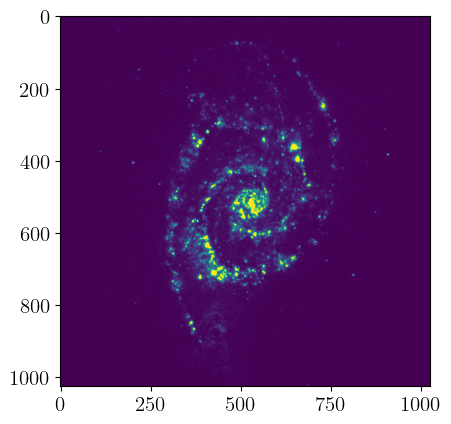

In [96]:
m51ha = fits.open('M51ha.fits')
datos_imagen = m51ha[0].data.squeeze()
m51ha.close()
ft_data = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(datos_imagen)))
plt.imshow(datos_imagen)
plt.show()


pix = datos_imagen.shape[0]

# Caso coordenadas no están en ENU

In [97]:
antenna_config_file = antenna_config_path + "vla.d.cfg"
data = np.loadtxt(antenna_config_file, dtype=dtype)

In [98]:
local_xyz = EarthLocation.from_geocentric(data["x"], data["y"], data["z"], u.m)

In [99]:
telescope_center = EarthLocation.of_site("vla")
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [100]:
enu_coords = earth_location_to_local_enu(local_xyz, telescope_center)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

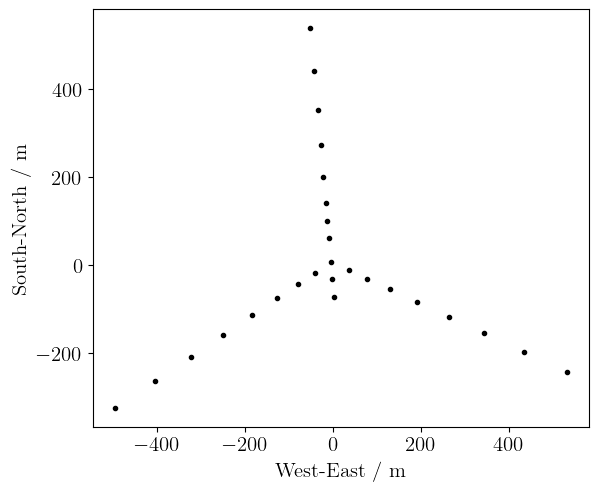

In [101]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [90]:
baseline_enu = baselines_enu(enu_coords)

In [91]:
baseline_equatorial = b_enu_to_b_equatorial(baseline_enu, latitude)

In [92]:
HA, dec = compute_HA(5, 25, 6)

In [93]:
cover = coverage(baseline_equatorial, HA, dec, wavelength)

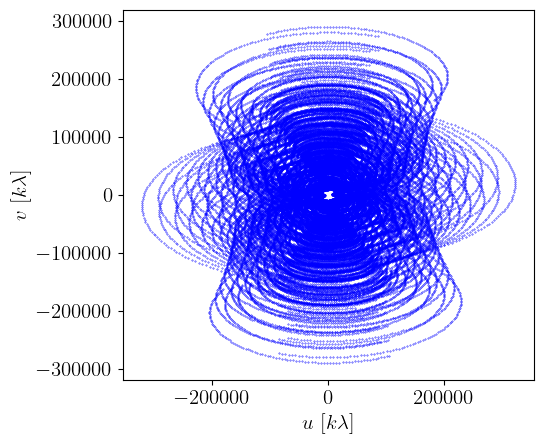

In [94]:
fig, ax = plt.subplots()
ax.scatter(cover[:,0],cover[:,1], c="blue", marker=".", s=0.4)
ax.set_xlabel(r'$u\ [k\lambda]$')
ax.set_ylabel(r'$v\ [k\lambda]$')
ax.set_aspect('equal')

# Caso las coordenadas ya están en ENU

In [102]:
antenna_config_file = antenna_config_path + "\\alma.cycle10.3.cfg"
dataENU = np.loadtxt(antenna_config_file, dtype=dtype)

In [103]:
enu_coords = np.vstack([dataENU["x"], dataENU["y"], dataENU["z"]])

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

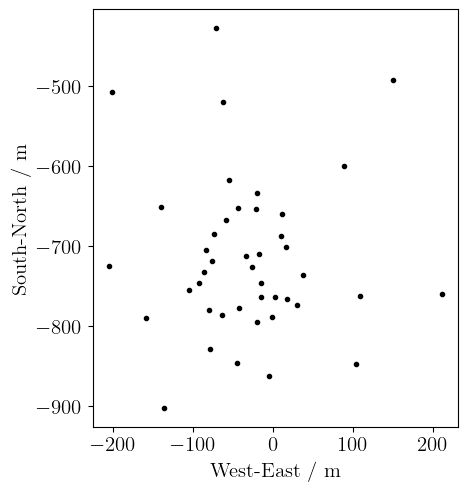

In [104]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [74]:
b_enu = baselines_enu(enu_coords)

In [75]:
telescope_center = EarthLocation.of_site("alma")
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [76]:
xyz_equatorial = b_enu_to_b_equatorial(b_enu, latitude)

In [77]:
HA, dec = compute_HA(1, -23.0000006847, 6)

In [78]:
cover = coverage(xyz_equatorial, HA, dec, wavelength)

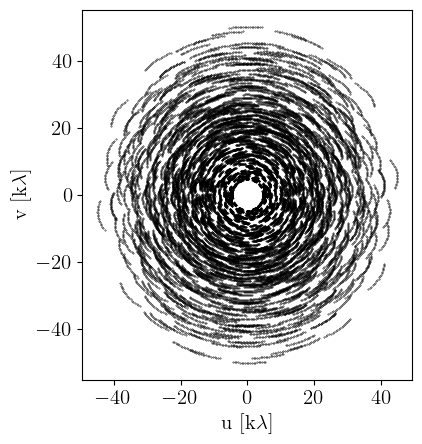

In [79]:
fig, ax = plt.subplots()
ax.scatter(cover[:,0]/1000,cover[:,1]/1000, c="black", marker=".", s=0.4)
ax.set_xlabel(r'u [k$ \lambda$]') 
ax.set_ylabel(r'v [k$ \lambda$]')
ax.set_aspect('equal')

In [80]:
sampling, psf = grid_sampling(pix, np.max(np.abs(xyz_equatorial)), cover, wavelength, "uniform", 1)

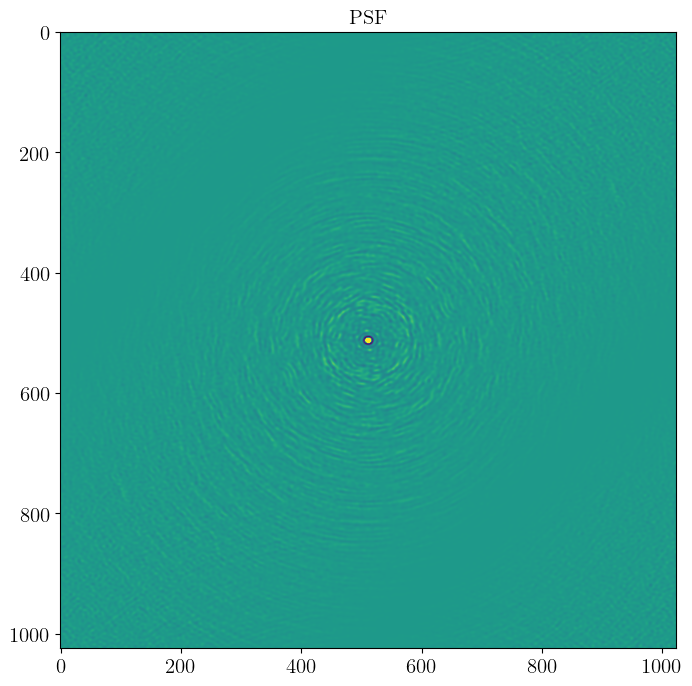

In [81]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('PSF')
plt.imshow(psf.real, vmax=0.1)

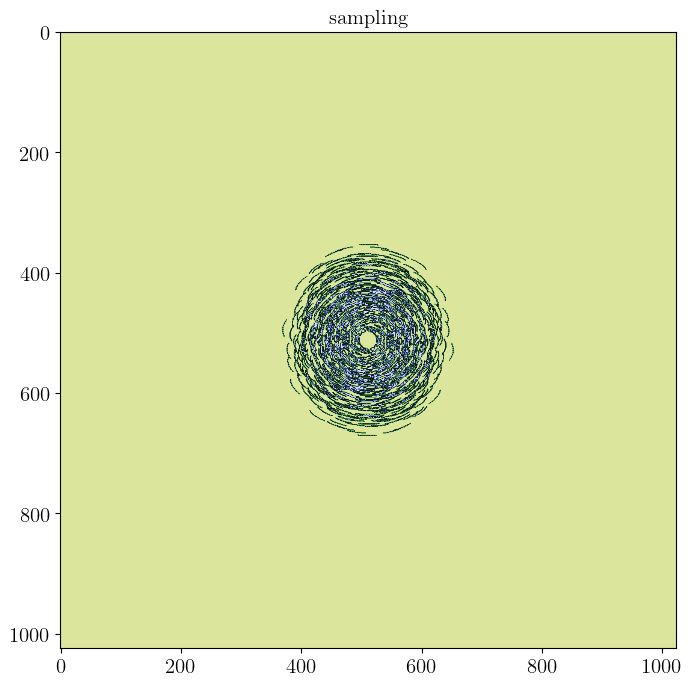

In [82]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('sampling')
plt.imshow(sampling, cmap=cmc.tofino_r)

In [83]:
obs  = (np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(ft_data*sampling)))).real

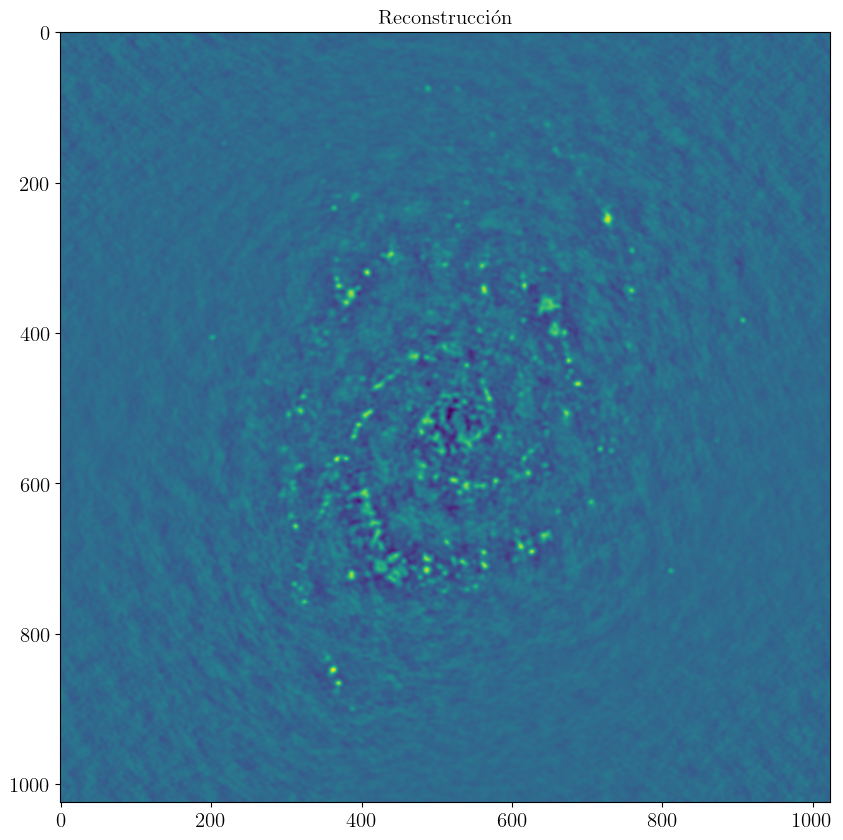

In [84]:
plt.figure(figsize=(10, 10))
plt.title('Reconstrucción')
plt.imshow(obs)